In [36]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint

PLOT_COLORS = {'vector': 'black', 'hybrid': 'darkorange', 'hybrid (weighted)': 'green'}
PLOT_LABEL = {'vector': 'vector', 'hybrid': 'hybrid', 'hybrid (weighted)': 'hybrid (weighted)'}

def select_color(s):
    if "vector" in s.lower():
        return PLOT_COLORS['vector']
    elif "hybrid" in s.lower():
        if "weighted" in s.lower():
            return PLOT_COLORS['hybrid (weighted)']
        else:
            return PLOT_COLORS['hybrid']

def select_plot_label(s):
    if "vector" in s.lower():
        return PLOT_LABEL['vector']
    elif "hybrid" in s.lower():
        if "weighted" in s.lower():
            return PLOT_LABEL['hybrid (weighted)']
        else:
            return PLOT_LABEL['hybrid']

In [37]:
df = pd.read_csv("/data/zyang/beyond_vector_search/data/results/k5_gk3_outputs/stats.res")
# pd.set_option("display.max_rows", None)
# mean_columns = [col for col in df.columns if "mean" in col or "filename" in col]
# df_mean = df[mean_columns]

# parse prob and cv from filename
cv_list = []
abs_prob_list = []
for index, row in df.iterrows():
    prob = float(row['filename'].split('prob')[-1][:3].replace('_', '.'))
    abs_prob_list.append(prob)
    cv = float(row['filename'].split('_num')[0].split('cv')[-1].replace('_', '.'))
    cv_list.append(cv)
df['prob'] = abs_prob_list
df['cv'] = cv_list

cvs = np.unique(df['cv'])

df.head()

,filename,distances_arxiv_vector_mean,distances_arxiv_vector_std,distances_arxiv_vector_max,distances_arxiv_vector_min,distances_hybrid_mean,distances_hybrid_std,distances_hybrid_max,distances_hybrid_min,distances_weighted_hybrid_mean,...,percent_include_hybrid_mean,percent_include_hybrid_std,percent_include_hybrid_max,percent_include_hybrid_min,percent_include_weighted_hybrid_mean,percent_include_weighted_hybrid_std,percent_include_weighted_hybrid_max,percent_include_weighted_hybrid_min,prob,cv
0,k5_gk3_cv0_05_num20_prob0_1.csv,1.235579,0.153563,1.410289,0.857804,1.276627,0.093184,1.415831,1.126943,1.224999,...,0.02,0.06,0.2,0.0,0.06,0.091652,0.2,0.0,0.1,0.05
1,k5_gk3_cv0_05_num20_prob0_3.csv,1.213290,0.212785,1.455439,0.785211,1.218100,0.201854,1.444036,0.732764,1.231333,...,0.06,0.18,0.6,0.0,0.04,0.120000,0.4,0.0,0.3,0.05
2,k5_gk3_cv0_05_num20_prob0_5.csv,1.124063,0.177157,1.382085,0.831222,1.146351,0.192669,1.400287,0.833608,1.142667,...,0.10,0.10,0.2,0.0,0.08,0.097980,0.2,0.0,0.5,0.05
3,k5_gk3_cv0_05_num20_prob1_0.csv,1.172288,0.154316,1.441961,0.977666,1.196668,0.167425,1.443637,0.861238,1.156029,...,0.04,0.08,0.2,0.0,0.06,0.128062,0.4,0.0,1.0,0.05
4,k5_gk3_cv0_1_num10_prob0_1.csv,1.321296,0.146769,1.447136,0.914756,1.321092,0.137647,1.436770,0.988970,1.334821,...,0.04,0.12,0.4,0.0,0.04,0.120000,0.4,0.0,0.1,0.10


In [38]:
def get_methods_metrcs(stats_row_dict, metric='accuracy', method_names=['arxiv_vector', 'hybrid', 'weighted_hybrid']):
    res_dict = {}
    res_std_dict = {}
    mean_keys = ["{}_{}_mean".format(metric, name) for name in method_names]
    std_keys = ["{}_{}_std".format(metric, name) for name in method_names]
    for i in range(len(mean_keys)):
        res_dict[mean_keys[i]] = stats_row_dict[mean_keys[i]]
        res_std_dict[std_keys[i]] = stats_row_dict[std_keys[i]]
    return res_dict, res_std_dict

def merge_metric_dict(md1, md2):
    # md1: {acc: x1} OR {acc: [x1, x2]}
    # md2: {acc: x3}
    # return {acc: [x1, x2]} OR {acc: [x1, x2, x3]}
    res = {}
    for k, v1 in md1.items():
        # if v1 is not a list, convert it to a list
        if not isinstance(v1, list):
            v1 = [v1]
        # check v2 from md2
        v2 = md2[k]
        if not isinstance(v2, list):
            v2 = [v2]
        res[k] = v1 + v2
    return res

In [39]:
# md1, _ = get_methods_metrcs(df.iloc[0])
# md2, _ = get_methods_metrcs(df.iloc[0])
# merge_metric_dict(md1, md2)

In [61]:
def parse_df(df, metric='accuracy'):
    mean_2dlist = {}
    std_2dlist = {}
    cvs = np.unique(df['cv'])
    for cv in cvs:
        df_cv = df[df['cv'] == cv]
        mergre_metric_dict = {}
        mergre_metric_std_dict = {}
        for index, row in df_cv.iterrows():
            stats_row_dict, stats_row_std_dict = get_methods_metrcs(row.to_dict(), metric=metric)
            if not mergre_metric_dict:
                mergre_metric_dict = stats_row_dict
            else:
                mergre_metric_dict = merge_metric_dict(mergre_metric_dict, stats_row_dict)
            
            if not mergre_metric_std_dict:
                mergre_metric_std_dict = stats_row_std_dict
            else:
                mergre_metric_std_dict = merge_metric_dict(mergre_metric_std_dict, stats_row_std_dict)

        mean_2dlist[cv] = mergre_metric_dict
        std_2dlist[cv] = mergre_metric_std_dict
    return mean_2dlist, std_2dlist

def get_plot_data(mean_2dlist, std_2dlist):
    plot_data = {} # method: {mean, std}
    for x in xs:
        # loop through each method
        for k, v in mean_2dlist[x].items():
            mean_data = []
            std_data = []
            max_data = []
            min_data = []
            mean_data.append(np.mean(v))
            max_data.append(np.max(v))
            min_data.append(np.min(v))

            std_key = k.replace("mean", "std")
            std_data.append(np.mean(std_2dlist[x][std_key]))
            
            if k not in plot_data:
                plot_data[k] = {}
                plot_data[k]['mean'] = mean_data
                plot_data[k]['max'] = max_data
                plot_data[k]['min'] = min_data
                plot_data[k]['std'] = std_data
            else:
                plot_data[k]['mean'] += mean_data
                plot_data[k]['max'] += max_data
                plot_data[k]['min'] += min_data
                plot_data[k]['std'] += std_data
    return plot_data

def plot_cv_metric(xs, plot_data, figure_size, ylabel, xlabel="Paper coverage", legend_loc='center left'):
    plt.figure(figsize=figure_size)
    for m, vd in plot_data.items():
        mean_data = vd['mean']
        max_data = vd['max']
        min_data = vd['min']
        mlabel = select_plot_label(m)
        # plt.fill_between(xs, min_data, max_data, color=select_color(m), alpha=0.35)
        plt.plot(xs, mean_data, label=mlabel, color = select_color(m))
        plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(loc=legend_loc)

## [1 workload] Paper coverage vs. distance mean

In [62]:
figure_size = (4.5, 2.7)

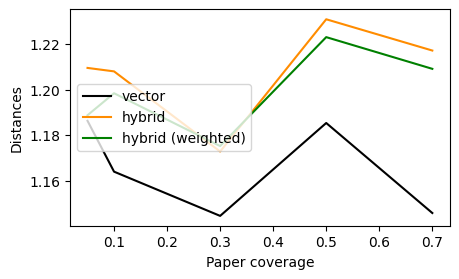

In [63]:
mean_2dlist, std_2dlist = parse_df(df, metric='distances')

# make a line plot. x-axis: cv, y-axis: mean_acc
xs = np.array(cvs)
plot_data = get_plot_data(mean_2dlist, std_2dlist)

# plt.figure(figsize=figure_size)
# for m, vd in plot_data.items():
#     mean_data = vd['mean']
#     max_data = vd['max']
#     min_data = vd['min']
    
#     mlabel = select_plot_label(m)
#     plt.plot(xs, mean_data, label=mlabel, color = select_color(m))
#     # plt.fill_between(xs, min_data, max_data, color=select_color(m), alpha=0.3)
#     # plt.ylim([1, 1.2])
#     plt.tight_layout()

# plt.ylabel("Distances")
# plt.xlabel("cv")
# plt.legend(loc='center left')
# plt.show()

plot_cv_metric(xs, plot_data, figure_size, ylabel="Distances", legend_loc='center left')

## [1 workloads] Paper coverage vs. acc mean

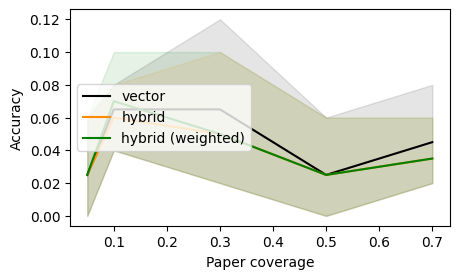

In [51]:
mean_2dlist, std_2dlist = parse_df(df, metric='accuracy')

# make a line plot. x-axis: cv, y-axis: mean_acc
xs = np.array(cvs)
plot_cv_metric(xs, get_plot_data(mean_2dlist, std_2dlist), figure_size, ylabel="Accuracy", legend_loc='center left')

## [1 workloads] Paper coverage vs. include mean

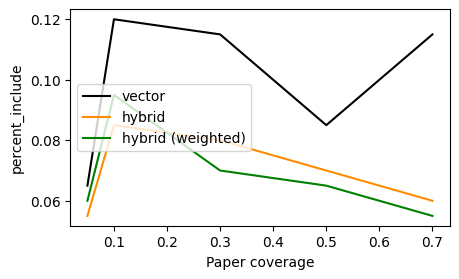

In [44]:
mean_2dlist, std_2dlist = parse_df(df, metric='percent_include')

# make a line plot. x-axis: cv, y-axis: mean_acc
xs = np.array(cvs)
plot_cv_metric(xs, get_plot_data(mean_2dlist, std_2dlist), figure_size, ylabel="percent_include", legend_loc='center left')
plt.show()

## [Multiple workloads && same k] gk vs. performance

In [25]:
import ast
import pandas as pd

def list_to_str(l):
    # given a python list obj: [1,2,3]
    # return a string: "[1,2,3]"
    # pandas can not handle list obj on a single cell...
    return str(l).replace(' ', '')

l = [[1,2], [2,3], [4,5]]
l = [list_to_str(x) for x in l]

psl = pd.Series(l)

In [28]:
psl[0]

tmp = "['math/0503320','math/0503321','1506.0568','1907.02667','2001.01329']"
a = ast.literal_eval(tmp)

In [35]:
a = "xxx"
a

'xxx'

## [Multiple workloads] k vs. performance